# Trabalho Prático de Interação e Concorrência

- Pedro Costa A87959
- Rui Faria A87957

## Enunciado

Each group of students has a number assigned, N.

Now, you have to use a quantum algorithm to find s
##### s = N mod 8
in an unsorted list.
Implement the correct algorithm in a Jupyter Notebook file. 
Each work should contain (and will be evaluated on) the following steps:
1. Division of the algorithm into sections; Utilisation of the state vector
simulator to explain each step (special attention to the oracle);
2. Application of noise simulator to predict the best optimisation; 
3. Execution in an IBM Q backend. 
4. Mitigation of Error with Ignis.

## Implementação do Algoritmo de Groover para encontrar $s$

In [1]:
# Relevant QISKit modules
from qiskit import Aer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, transpile

from qiskit.tools.visualization import plot_histogram, visualize_transition, plot_state_city, plot_state_hinton

# Useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
backend_vector = Aer.get_backend("statevector_simulator")
backend_unitary = Aer.get_backend('unitary_simulator')
backend = Aer.get_backend("qasm_simulator")

- Queremos encontrar s = N mod 8 numa lista desordenada, onde N é igual ao número do nosso grupo.
- Vamos identificar primeiro qual o número que queremos encontrar.

In [3]:
N = 15
s = N % 8
print('Number that we are looking for:', s)

Number that we are looking for: 7


- Depois passsamos o número para binário.

In [4]:
sb = bin(s)[2:] 

print('Number in binary form:',sb)

Number in binary form: 111


- Precisamos então de 3 qubits.

In [5]:
x = len(sb)
print('Number of qubits:', x)

Number of qubits: 3


**1**  Inicializamos o sistema com a mesma amplitude em todos os estados de input.

$$ \sum_{x_i} \lvert x_i \rangle$$

**2** Aplica $\sqrt{N}$ vezes as seguintes operações unitárias:

**a)** Operador Quantum Oracle $U_w$. Este operador é responsável por identificar as soluções para o problema e indicar o que estamos à procura.

$$-\alpha_m \lvert x_m \rangle + \beta \sum_{x_i \neq x_m}\lvert x_i \rangle$$ 

Com esta implementação, a fase do estado marcado ($f(x_m) = 1$) roda $\pi$ radianos, enquanto os outros estados mantêm o sistema inalterado.

Como o oráculo apenas precisa de mudar o estado do que estamos à procura, então basta implementar uma porta $CCZ$, que no qiskit é representada pela composição de portas de $Hadamard$ e da porta $CCX$. Também não precisamos de usar nenhuma porta $X$, pois como queremos encontrar $|7\rangle = |111\rangle$ não necessitamos de usar essa porta. 

In [6]:
def phase_oracle(circuit, qr_x):
    circuit.h(qr_x[2])
    circuit.ccx(qr_x[0], qr_x[1], qr_x[2])
    circuit.h(qr_x[2])

Então uma representação do oráculo será:

Aplicação da porta de Hadamard
$$
(I \otimes I \otimes H)|000\rangle = I|0\rangle \otimes I|0\rangle \otimes H|0\rangle = \left[
\begin{array}{c}
\frac{1}{\sqrt{2}} \\
\frac{1}{\sqrt{2}} \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
\end{array}
\right]
$$

Aplicação da porta CCX
$$
CCX(|0\rangle,|0\rangle,\frac{|0\rangle + |1\rangle}{\sqrt{2}}) = \left[
\begin{array}{c}
\frac{1}{\sqrt{2}} \\
\frac{1}{\sqrt{2}} \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
\end{array}
\right]
$$

Aplicação da porta de Hadamard de novo
$$
(I \otimes I \otimes H)|0\rangle|0\rangle(\frac{|0\rangle + |1\rangle}{\sqrt{2}}) = \left[
\begin{array}{c}
1 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
\end{array}
\right]
$$

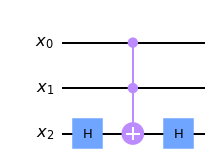

In [7]:
qr_x = QuantumRegister(x, 'x')
qc = QuantumCircuit(qr_x)
phase_oracle(qc, qr_x)

qc.draw(output='mpl')

Utilização do State Vector para simular os passos.

In [8]:
result = execute(qc, backend_vector).result()
qstate = result.get_statevector(qc)
print(qstate)

[1.00000000e+00-6.123234e-17j 0.00000000e+00+0.000000e+00j
 0.00000000e+00+0.000000e+00j 0.00000000e+00+0.000000e+00j
 4.26642159e-17+6.123234e-17j 0.00000000e+00+0.000000e+00j
 0.00000000e+00+0.000000e+00j 0.00000000e+00+0.000000e+00j]


**b)** Aplicar a tranformação de difusão $U_D$.  Chega-se à implementação deste operador através de $U_D=WRW$, onde $W$ é a matriz de transformação Walsh-Hadamard , e $R$ é a matriz de rotação.

$$(2A + \alpha_m)\lvert x_m \rangle + (2A-\beta)\sum_{x_i\neq x_m} \lvert x_i \rangle $$

Este passo do algoritmo não só altera o input desejado mas também aumenta a sua amplitude.

In [9]:
def diffuser(circuit, qr_x):
    circuit.h(qr_x)
    circuit.x(qr_x)
    phase_oracle(circuit, qr_x)
    circuit.x(qr_x)
    circuit.h(qr_x)

Estes passos (a) e (b) têm de ser repetidos $\sqrt{N}$ vezes para chegar ao valor mais aproximado.

In [10]:
import math as m
times= round(m.sqrt(2**x))
print(times)

3


- Vamos agora criar um Registo Clássico para guardar a informação após a medição dos qubits e, depois, um Circuito Quântico (circuito de Grover) com um registo quântico $qr\_x$ e também com o registo clássico $cr$. O circuito é inicializado com a mesma amplitude em todos os estados de input.

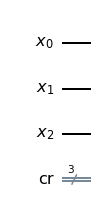

In [11]:
cr = ClassicalRegister(x,'cr')
qc_Grover = QuantumCircuit(qr_x,cr)
qc_Grover.draw(output='mpl')

Utilizando o State Vector obtemos a matriz 

$$
|000\rangle = \left[
\begin{array}{c}
1 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
\end{array}
\right]
$$

In [12]:
result = execute(qc_Grover, backend_vector).result()
qstate = result.get_statevector(qc_Grover)
print(qstate)

[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


- Aplicar uma gate de Hadamard a cada qubit, ou seja, aplicar $H^{\otimes n}$.
$$
H|000\rangle = H(|0\rangle \otimes |0\rangle \otimes |0\rangle) = H|0\rangle \otimes H|0\rangle \otimes H|0\rangle = \left[
\begin{array}{c}
\frac{1}{2\sqrt{2}} \\
\frac{1}{2\sqrt{2}} \\
\frac{1}{2\sqrt{2}} \\
\frac{1}{2\sqrt{2}} \\
\frac{1}{2\sqrt{2}} \\
\frac{1}{2\sqrt{2}} \\
\frac{1}{2\sqrt{2}} \\
\frac{1}{2\sqrt{2}} \\
\end{array}
\right]
$$

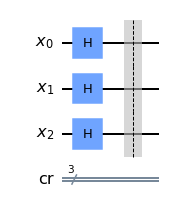

In [13]:
qc_Grover.h(qr_x)
qc_Grover.barrier()
qc_Grover.draw(output='mpl')

In [14]:
result = execute(qc_Grover, backend_vector).result()
qstate = result.get_statevector(qc_Grover)
print(qstate)

[0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j
 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j]


- Como só precisamos de encontrar um elemento, a variável $t$ só é executada uma vez.
- Dentro do ciclo for é executado o oráculo.

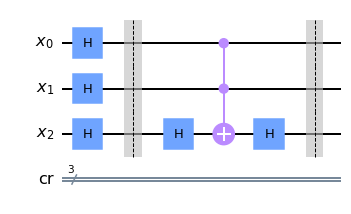

In [15]:
for t in range(1):
    # a)
    phase_oracle(qc_Grover, qr_x)
    qc_Grover.barrier()

qc_Grover.draw(output='mpl')

In [16]:
result = execute(qc_Grover, backend_vector).result()
qstate = result.get_statevector(qc_Grover)
print(qstate)

[ 0.35355339+4.37824579e-33j  0.35355339+4.37824579e-33j
  0.35355339+4.37824579e-33j  0.35355339-4.32978028e-17j
  0.35355339-4.32978028e-17j  0.35355339-4.32978028e-17j
  0.35355339-4.32978028e-17j -0.35355339+8.65956056e-17j]


- Agora executamos o difusor.

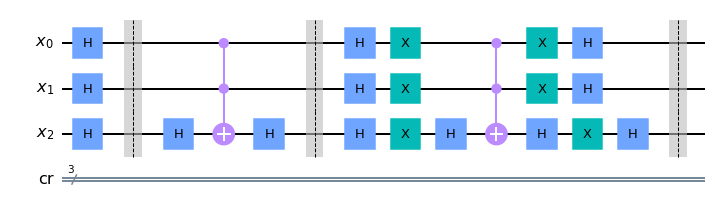

In [17]:
for t in range(1):
    # b)
    diffuser(qc_Grover,qr_x)
    qc_Grover.barrier()
    
qc_Grover.draw(output='mpl')

In [18]:
result = execute(qc_Grover, backend_vector).result()
qstate = result.get_statevector(qc_Grover)
print(qstate)

[-0.1767767 +2.03637921e-35j -0.1767767 +2.16489014e-17j
 -0.1767767 +2.16489014e-17j -0.1767767 -2.66556279e-32j
 -0.1767767 +1.35579187e-17j -0.1767767 -8.09098269e-18j
 -0.1767767 -8.09098269e-18j -0.88388348+1.32517455e-16j]


- Por fim, medimos o circuito.
- Desenho do circuito completo.

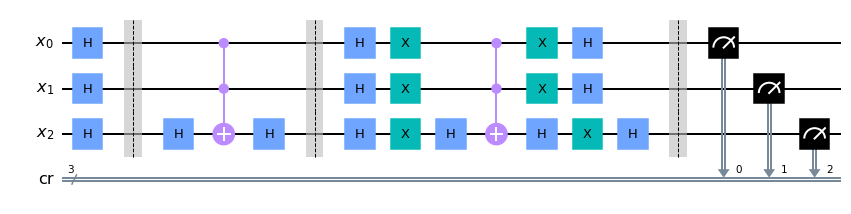

In [19]:
qc_Grover.measure(qr_x,cr)
qc_Grover.draw(output='mpl')

In [20]:
result = execute(qc_Grover, backend_vector).result()
qstate = result.get_statevector(qc_Grover)
print(qstate)

[-0.+0.00000000e+00j -0.+0.00000000e+00j -0.+0.00000000e+00j
  0.-0.00000000e+00j -0.+0.00000000e+00j  0.+0.00000000e+00j
  0.+0.00000000e+00j -1.+1.49926386e-16j]


- Desenha o histograma com as probabilidades das medições.

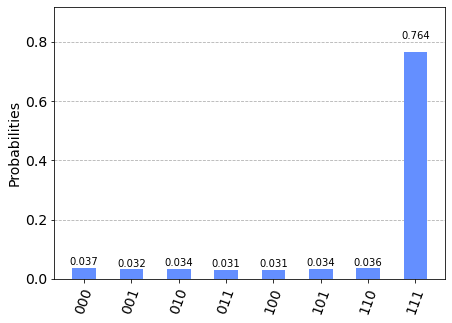

In [21]:
shots=1024
result = execute(qc_Grover, backend, shots=shots).result()
counts_Grover = result.get_counts(qc_Grover)
plot_histogram(counts_Grover)

- Profundidade do circuito, caminho mais longo entre o input e o output.

In [22]:
qc_Grover.depth()

12

## Noise Simulator

- Load da Conta IBMQ.

In [23]:
provider = IBMQ.load_account()
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') fr

- Visualização dos Computadores Quânticos. 

In [24]:
import qiskit.tools.jupyter

%qiskit_backend_overview

- Ver informações em específico sobre qual o computador quântico menos ocupado no momento.

In [25]:
backends_list =provider.backends( simulator=False, open_pulse=False)

from qiskit.providers.ibmq import least_busy

backend_device = least_busy(backends_list)
print("Running on current least busy device: ", backend_device)

backend_device

Running on current least busy device:  ibmqx2


<IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>

In [26]:
coupling_map = backend_device.configuration().coupling_map

In [27]:
from qiskit.providers.aer.noise import NoiseModel

- Construção do modelo Noise a partir de propriedades backend.

In [28]:
noise_model = NoiseModel.from_backend(backend_device)
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['cx', 'reset', 'measure', 'x', 'sx', 'id']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('sx', [0]), ('sx', [1]), ('sx', [2]), ('sx', [3]), ('sx', [4]), ('x', [0]), ('x', [1]), ('x', [2]), ('x', [3]), ('x', [4]), ('cx', [4, 2]), ('cx', [2, 4]), ('cx', [3, 4]), ('cx', [4, 3]), ('cx', [3, 2]), ('cx', [2, 3]), ('cx', [1, 2]), ('cx', [2, 1]), ('cx', [0, 2]), ('cx', [2, 0]), ('cx', [0, 1]), ('cx', [1, 0]), ('reset', [0]), ('reset', [1]), ('reset', [2]), ('reset', [3]), ('reset', [4]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]


- Obter os gates base do modelo noise.

In [29]:
basis_gates = noise_model.basis_gates
print(basis_gates)

['cx', 'id', 'reset', 'rz', 'sx', 'x']


- Executa simulação do modelo noise e obtém os counts.

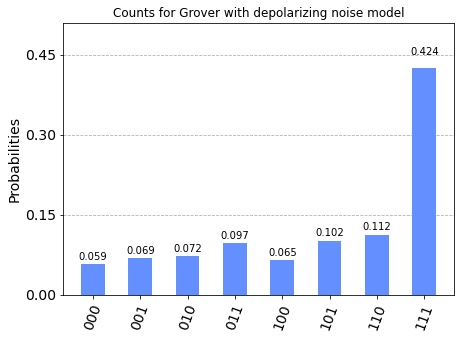

In [30]:
result_noise = execute(qc_Grover, backend, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()

counts_noise = result_noise.get_counts(qc_Grover)
plot_histogram(counts_noise, title="Counts for Grover with depolarizing noise model")

- Imprime o count de Grover.

In [31]:
print(counts_Grover)

{'111': 782, '001': 33, '110': 37, '000': 38, '011': 32, '100': 32, '010': 35, '101': 35}


- Imprime o count do modelo noise.

In [32]:
print(counts_noise)

{'111': 434, '011': 99, '101': 104, '000': 60, '110': 115, '001': 71, '010': 74, '100': 67}


In [33]:
def resume(counts_raw):
    s0=s1=0
    k=counts_raw.keys()
    lk=list(k)
    for c in lk:
        if c[0]=='0':
            s0 = s0 + counts_raw.get(c)
        else:
            s1 = s1 + counts_raw.get(c)
    return({'0':s0, '1':s1})

In [34]:
cn = resume(counts_noise)
c = resume(counts_Grover)

- Desenha o histograma.

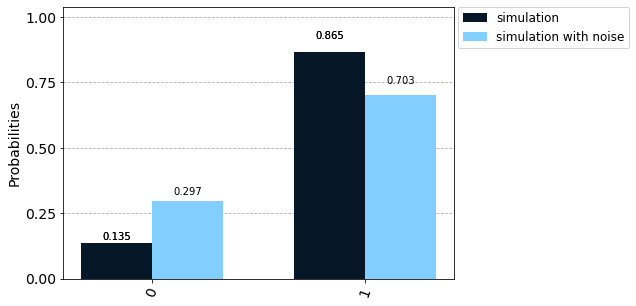

In [35]:
plot_histogram([c,cn], legend= ['simulation','simulation with noise'], color=['#061727','#82cfff'])

## IBM Q Provider

Devolve a lista dos computadores quânticos.

In [36]:
from qiskit.tools.monitor import backend_overview, backend_monitor

backend_overview()

ibmq_manila                  ibmq_quito                   ibmq_belem
-----------                  ----------                   ----------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 23             Pending Jobs: 19             Pending Jobs: 0
Least busy:   False          Least busy:   False          Least busy:   True
Operational:  True           Operational:  True           Operational:  True
Avg. T1:      148.5          Avg. T1:      80.3           Avg. T1:      75.9
Avg. T2:      68.2           Avg. T2:      71.2           Avg. T2:      75.6



ibmq_lima                    ibmq_santiago                ibmq_athens
---------                    -------------                -----------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 7              Pending Jobs: 24             Pending Jobs: 3
Least busy:   False          Least busy:   False          Least busy:   False
Operational:  True           Operatio

- Vamos ver qual o computador quântico menos ocupado.

In [37]:
print("Running on current least busy device: ", backend_device)

Running on current least busy device:  ibmqx2


In [38]:
backend_monitor(backend_device)

ibmqx2
Configuration
-------------
    n_qubits: 5
    operational: True
    status_msg: active
    pending_jobs: 1
    backend_version: 2.3.6
    basis_gates: ['id', 'rz', 'sx', 'x', 'cx', 'reset']
    local: False
    simulator: False
    conditional: False
    meas_kernels: ['hw_boxcar']
    qubit_lo_range: [[4.78233846827291e+18, 5.78233846827291e+18], [4.747504372507464e+18, 5.747504372507464e+18], [4.533385431152394e+18, 5.533385431152394e+18], [4.791961703900664e+18, 5.791961703900664e+18], [4.578440770845786e+18, 5.578440770845786e+18]]
    pulse_num_channels: 9
    supported_instructions: ['rz', 'acquire', 'x', 'cx', 'sx', 'reset', 'u1', 'id', 'measure', 'play', 'u2', 'shiftf', 'delay', 'u3', 'setf']
    u_channel_lo: [[{'q': 1, 'scale': (1+0j)}], [{'q': 2, 'scale': (1+0j)}], [{'q': 0, 'scale': (1+0j)}], [{'q': 2, 'scale': (1+0j)}], [{'q': 0, 'scale': (1+0j)}], [{'q': 1, 'scale': (1+0j)}], [{'q': 3, 'scale': (1+0j)}], [{'q': 4, 'scale': (1+0j)}], [{'q': 2, 'scale': (1+0j)}], [

In [39]:
# Informação backend
backend_device

<IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>

In [40]:
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

- Imprime o ID que será utilizado para executar o circuito definido no computador quântico escolhido.

In [41]:
job_Grover_r = execute(qc_Grover, backend_device, shots=shots)

jobID_Grover_r = job_Grover_r.job_id()

print('JOB ID: {}'.format(jobID_Grover_r))

JOB ID: 60bd374d5f4eaa0098dafef9


In [43]:
job_get=backend_device.retrieve_job("60bd374d5f4eaa0098dafef9")

result_Grover_r = job_get.result()
counts_Grover_run = result_Grover_r.get_counts(qc_Grover)

- Desenha o histograma.

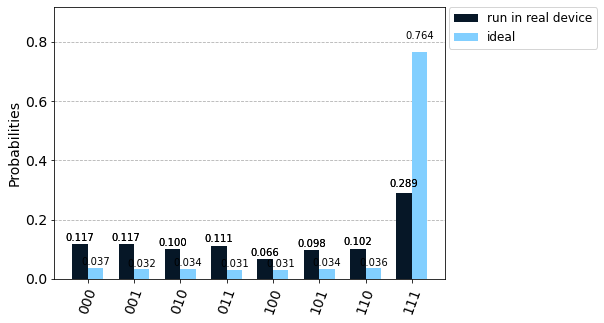

In [44]:
plot_histogram([counts_Grover_run, counts_Grover], legend=[ 'run in real device', 'ideal'], color=['#061727','#82cfff'])

- Desenha o circuito.

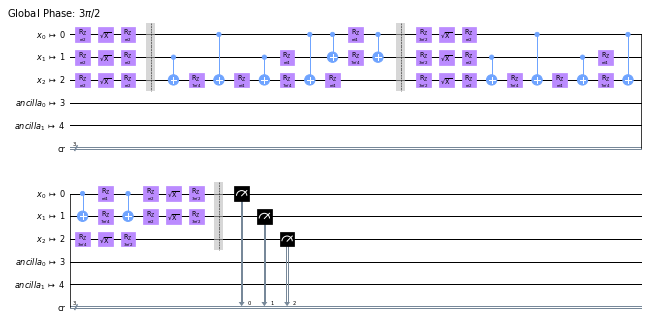

In [45]:
from qiskit.compiler import transpile

qc_t_real = transpile(qc_Grover, backend=backend_device)

qc_t_real.draw(output='mpl', scale=0.5)

- Otimiza o circuito.

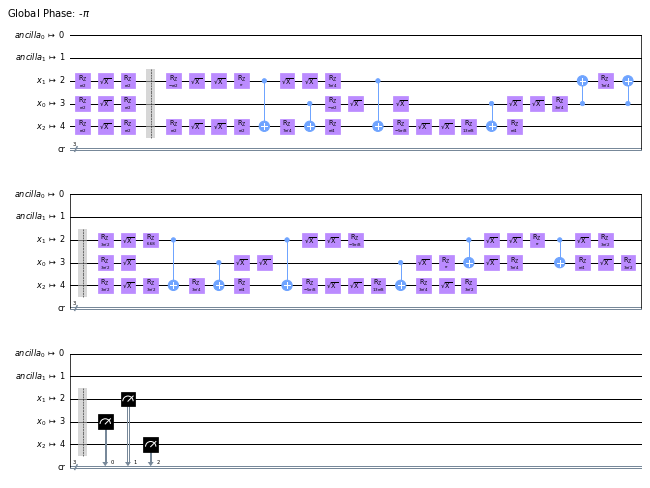

In [46]:
qc_optimized = transpile(qc_Grover, backend=backend_device, optimization_level=3)
qc_optimized.draw(output='mpl', scale=0.5)

- Profundidade do circuito de Grover.

In [47]:
qc_Grover.depth()

12

- Profundidade real do circuito executado anteriormente.

In [48]:
qc_t_real.depth()

30

- Desenha o layout do circuito.

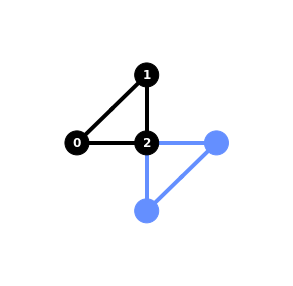

In [49]:
from qiskit.visualization import plot_circuit_layout
plot_circuit_layout(qc_t_real, backend_device)

- Profundidade do circuito otimizado.

In [50]:
qc_optimized.depth()

47

- Desenho do circuito otimizado.

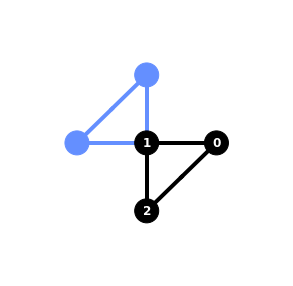

In [51]:
plot_circuit_layout(qc_optimized, backend_device)

- Executa o circuito otimizado no computador quântico.

In [52]:
job_exp = execute(qc_optimized, backend_device, shots = shots)

# job_id allows you to retrive old jobs
jobID = job_exp.job_id()

print('JOB ID: {}'.format(jobID))

job_exp.result().get_counts(qc_optimized)

JOB ID: 60bd379b1eb0243bf1cefbcb


{'000': 103,
 '001': 70,
 '010': 109,
 '011': 96,
 '100': 83,
 '101': 113,
 '110': 89,
 '111': 361}

In [53]:
#with optimization 2
job_get_o=backend_device.retrieve_job("60bd379b1eb0243bf1cefbcb")

result_real_o = job_get_o.result(timeout=3600, wait=5)

counts_opt = result_real_o.get_counts(qc_optimized)

In [54]:
%qiskit_disable_job_watcher

- Desenha o histograma

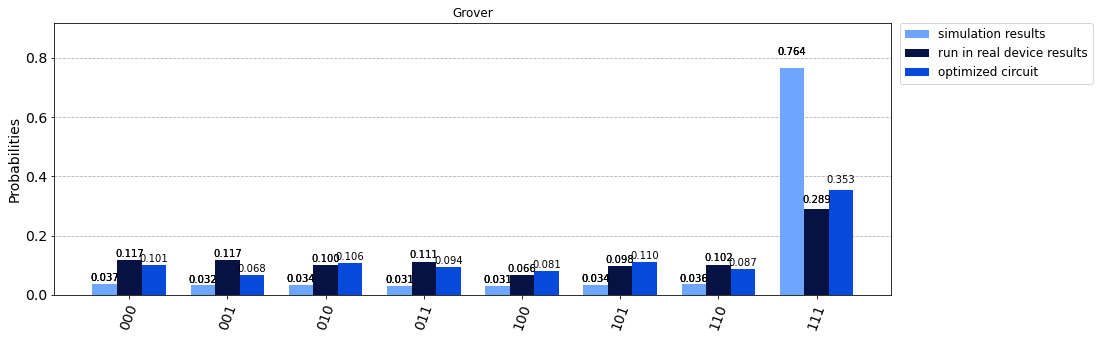

In [55]:
title = 'Grover'
legend = [ 'simulation results','run in real device results', 'optimized circuit']
color = ['#6ea6ff','#051243','#054ada']

plot_histogram([counts_Grover, counts_Grover_run, counts_opt], legend = legend, title= title, color=color, figsize=(15, 5))

## IGNIS

- Importa as funções de medida e calibração.

In [56]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

- Gera os circuitos de calibração.

In [57]:
qr = QuantumRegister(x)
meas_calibs, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr, circlabel='mcal')

- Lista de estados.

In [58]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

- Descobre o ID.

In [59]:
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [60]:
job_ignis = execute(meas_calibs, backend=backend_device, shots=shots)

jobID_run_ignis = job_ignis.job_id()

print('JOB ID: {}'.format(jobID_run_ignis))

JOB ID: 60bd3807917aa0525e9b7fe6


- Obtém os Resultados.

In [61]:
job_get=backend_device.retrieve_job("60bd3807917aa0525e9b7fe6")

cal_results = job_get.result()

In [62]:
%qiskit_disable_job_watcher

- Faz um mapa da matriz de calibração.

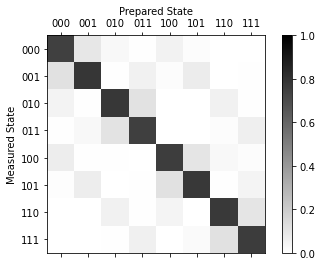

In [63]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

# Plot the calibration matrix
meas_fitter.plot_calibration()

In [64]:
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())

Average Measurement Fidelity: 0.767456


- Obtém o objeto de filtro.

In [65]:
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(result_Grover_r)
mitigated_counts = mitigated_results.get_counts()

- Desenha o histograma.

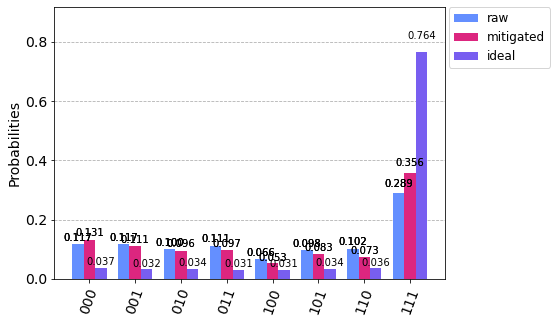

In [66]:
plot_histogram([counts_Grover_run, mitigated_counts, counts_Grover], legend=['raw', 'mitigated', 'ideal'])